In [1]:
import os
import keras
import nltk
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm 
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten,BatchNormalization, Activation, Input, Add, Concatenate
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

print(keras.__version__)
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

Using TensorFlow backend.
2.2.4


In [2]:
def load_data(file_name):
    df = pd.read_csv(file_name)
    return df["review_id"], df["text"], df["stars"]

def load_labels(file_name):
    return pd.read_csv(file_name)["stars"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["review_id", "stars"]
    df.to_csv(file_name, index=False)

In [3]:
def tokenize(text):
    return nltk.word_tokenize(text)
    
def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]
def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [4]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

In [5]:
train_data = pd.read_csv("data/train.csv")
valid_data = pd.read_csv("data/valid.csv")

In [6]:
print("Train data tokenization")
train_tokens = [tokenize(text) for text in train_data["text"]]
print("Validation data tokenization")
valid_tokens = [tokenize(text) for text in valid_data["text"]]

print("Train data stem")
train_stemmed = [stem(tokens) for tokens in train_tokens]
print("Validation data stem")
valid_stemmed = [stem(tokens) for tokens in valid_tokens]

print("Train data removing stop words")
train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
print("Validation data removing stop words")
valid_stemmed = [filter_stopwords(tokens) for tokens in valid_stemmed]

Train data tokenization
Validation data tokenization
Train data stem
Validation data stem
Train data removing stop words
Validation data removing stop words


In [7]:
min_freq = 3
train_feats = train_stemmed
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 12644


In [8]:
from gensim.models import word2vec

print("Start Word2Vec")
word2vec_model = word2vec.Word2Vec(train_stemmed, min_count=min_freq, size=100, workers=4, iter=10)

unable to import 'smart_open.gcs', disabling that module
Start Word2Vec


In [9]:
NUM_OF_WORDS = len(feats_dict)
EMBEDDING_SIZE = word2vec_model.wv.vectors.shape[1]

# Construct the Embedding Matrix
embedding_matrix = np.zeros((NUM_OF_WORDS, EMBEDDING_SIZE))
for i, word in enumerate(feats_dict.keys()):
    try:
        vector = word2vec_model[word]
        embedding_matrix[i] = vector
    except KeyError:
        print(f"cannot find word\"{word}\"")
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_SIZE)

In [10]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_SENTENCE_LENGTH = 300
NUM_CLASSES = max(train_data["stars"])

train_feats = np.vstack([get_index_vector(f, feats_dict, MAX_SENTENCE_LENGTH) for f in train_stemmed])
valid_feats = np.vstack([get_index_vector(f, feats_dict, MAX_SENTENCE_LENGTH) for f in valid_stemmed])

x_train = pad_sequences(train_feats, maxlen=MAX_SENTENCE_LENGTH)
x_valid = pad_sequences(valid_feats, maxlen=MAX_SENTENCE_LENGTH)

y_train = to_categorical(np.asarray(train_data["stars"] - 1), num_classes=NUM_CLASSES)
y_valid = to_categorical(np.asarray(valid_data["stars"] - 1), num_classes=NUM_CLASSES)

print(f"Max Sentence Length: {MAX_SENTENCE_LENGTH}")
print(f"Number of Classes: {NUM_CLASSES}")

Max Sentence Length: 300
Number of Classes: 5


In [11]:
print(len(x_train))
print(len(y_train))
print(len(feats_dict))

20000
20000
12644


In [12]:
input_size=len(feats_dict)
print(input_size)
output_size=NUM_CLASSES
print(NUM_CLASSES)
input_length=MAX_SENTENCE_LENGTH
hidden_size=100
embedding_size=100
l2_reg = 0.1
learning_rate=0.1
loss="categorical_crossentropy"
metric="accuracy"


12644
5


In [25]:
keras.backend.clear_session()
from keras.optimizers import SGD, Adam
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import SpatialDropout1D
from keras.layers import concatenate
words = Input(shape=(None, ))
x = Embedding(input_dim=input_size,
                    output_dim=100,
                    input_length=input_length,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)(words)

x = SpatialDropout1D(0.2)(x)
# return_sequence: whether to return the last output or not
x = Bidirectional(LSTM(units=80, return_sequences=True))(x)
x = Bidirectional(LSTM(units=40, return_sequences=True))(x)

hidden_layer = concatenate([GlobalMaxPooling1D()(x), GlobalMaxPooling1D()(x)])
hidden_layer = Dense(100,activation='relu')(hidden_layer)
hidden_layer = Dropout(0.2)(hidden_layer)
hidden_layer = Dense(50,activation='tanh')(hidden_layer)
#hidden_layer = Dropout(0.2)(hidden_layer)

result = Dense(units=output_size,activation='softmax')(hidden_layer)
model = Model(inputs = words, outputs=result)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001, decay=0.000025),metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 100)     1264400     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 300, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 300, 160)     115840      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

In [26]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join("/Users/yihanliao/Documents/COMP4332/PA1/models", "model_hehe7.hdf5"), monitor="val_acc", verbose=1, save_best_only=True)


In [27]:
earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
callbacks = [checkpointer, earlystopping]

In [28]:
history = model.fit(x_train, y_train,
                    batch_size=50,
                    epochs=20,
                    validation_data=(x_valid, y_valid), verbose=1, callbacks=callbacks)

Train on 20000 samples, validate on 2000 samples
Epoch 1/20
20000/20000 [==============================] - 304s 15ms/step - loss: 1.0127 - acc: 0.5841 - val_loss: 0.8638 - val_acc: 0.6275

Epoch 00001: val_acc improved from -inf to 0.62750, saving model to /Users/yihanliao/Documents/COMP4332/PA1/models/model_hehe7.hdf5
Epoch 2/20
20000/20000 [==============================] - 296s 15ms/step - loss: 0.8704 - acc: 0.6345 - val_loss: 0.8525 - val_acc: 0.6425

Epoch 00002: val_acc improved from 0.62750 to 0.64250, saving model to /Users/yihanliao/Documents/COMP4332/PA1/models/model_hehe7.hdf5
Epoch 3/20
20000/20000 [==============================] - 294s 15ms/step - loss: 0.8245 - acc: 0.6544 - val_loss: 0.8324 - val_acc: 0.6435

Epoch 00003: val_acc improved from 0.64250 to 0.64350, saving model to /Users/yihanliao/Documents/COMP4332/PA1/models/model_hehe7.hdf5
Epoch 4/20
20000/20000 [==============================] - 299s 15ms/step - loss: 0.7919 - acc: 0.6673 - val_loss: 0.8114 - val_ac

In [43]:
eval_model = keras.models.load_model(os.path.join("/Users/yihanliao/Documents/COMP4332/PA1/models", "model_hehe7.hdf5"))
train_loss, train_acc = eval_model.evaluate(x_train, y_train, batch_size=50)
valid_loss, valid_acc = eval_model.evaluate(x_valid, y_valid, batch_size=50)
print("training loss:", train_loss, " training accuracy", train_acc)
print("test loss:", valid_loss, " test accuracy", valid_acc)

2000/2000 [==============================] - 6s 3ms/step
training loss: 0.6453281182050705  training accuracy 0.7267500026524067
test loss: 0.786241714656353  test accuracy 0.6750000014901161


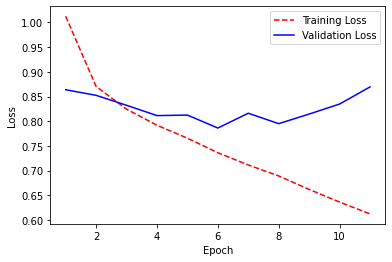

In [35]:
epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

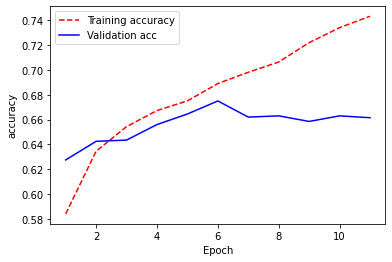

In [36]:
epoch_count = range(1, len(history.history['acc']) + 1)

plt.plot(epoch_count, history.history['acc'], 'r--')
plt.plot(epoch_count, history.history['val_acc'], 'b-')
plt.legend(['Training accuracy', 'Validation acc'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

In [37]:
test_data = pd.read_csv("data/test.csv")

In [60]:
test_tokens = [tokenize(text) for text in test_data["text"]]
test_stemmed = [stem(tokens) for tokens in test_tokens]
test_stemmed = [filter_stopwords(tokens) for tokens in test_stemmed]
test_feats = np.vstack([get_index_vector(f, feats_dict, MAX_SENTENCE_LENGTH) for f in test_stemmed])
x_test = pad_sequences(test_feats, maxlen=MAX_SENTENCE_LENGTH)
y_test = eval_model.predict(x_test)
predicts_class = np.argmax(y_test, axis=1)
pd.DataFrame({"review_id": test_data["review_id"], "stars": predicts_class + 1}).to_csv(os.path.join("pred.csv"), index=False)

In [44]:
y_rounded = y_test.argmax(axis=-1)
print(y_rounded, y_rounded+1)
final_y = y_rounded+1
print(len(final_y))

[2 3 4 ... 2 0 4] [3 4 5 ... 3 1 5]
2000


In [61]:
import collections

# distribution in test data
prediction = Counter()
prediction.update(sorted(y_rounded))
prediction

Counter({0: 381, 1: 77, 2: 212, 3: 372, 4: 958})

In [56]:
# distribution in train data

y1 = Counter()
y1.update(sorted(y_train.argmax(axis=-1)))
y1


Counter({0: 2931, 1: 1577, 2: 2229, 3: 4426, 4: 8837})

In [58]:
# distribution in valid data
y2 = Counter()
y2.update(sorted(y_valid.argmax(axis=-1)))
y2

Counter({0: 315, 1: 177, 2: 207, 3: 440, 4: 861})